In [32]:
import numpy as np
import pandas as pd
from numpy.random import uniform, normal  
import math
from math import pi
from scipy.optimize import Bounds
from scipy.optimize import minimize
import matplotlib.pyplot as plt 
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [33]:
def J_square(sigma_square,tau_square):
    return tau_square/(tau_square+sigma_square)

In [34]:
# k: the number of studies
k_list = [10,30,50,100]
# each element of `parameter_constellation` has the form (mu, sigma^2,tau^2) 
# where tau^2 is the between-study variance, sigma^2*u_i is the within-study variance
parameter_constellation = [(0,12,4),(0,9,4),(0,4,4),(0,2,6)]
# heterogeniety measure: J^2
J_square_list = list()
for element in parameter_constellation:
    sigma_square_i = element[1]
    tau_square_i = element[2]
    J_square_list.append(J_square(sigma_square_i,tau_square_i))
print('J square =',J_square_list)

J square = [0.25, 0.3076923076923077, 0.5, 0.75]


## method1: trying to minimize the negative log likelihood
CO (constrained optimization): using $\sigma/\tau$ instead of $\sigma^2/\tau^2$

### The negative log-likelihood function of $v = (\mu, \sigma^2, \tau^2)$ is given by

$I(v) = \frac{1}{2}\sum \limits_{i=1}^{k}[\frac{(D_i-\mu)^2}{\tau^2+\sigma^2 u_i}+\log{(\tau^2+\sigma^2 u_i)}+c]$

with jacobian matrix (which cannot be calculated automatically in numpy):

$$\frac{\partial l(v)}{\partial \mu} = \sum \limits_{i=1}^{k} \frac{D_i - \mu}{\tau^2 + \sigma^2 u_i}$$

$$\frac{\partial l(v)}{\partial \sigma^2} = \sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2 u_i}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{u_i}{\tau^2+\sigma^2u_i} \Rightarrow \frac{\partial l(v)}{\partial \sigma} = \frac{\partial l(v)}{\partial \sigma^2} \cdot 2 \sigma = (\sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2 u_i}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{u_i}{\tau^2+\sigma^2u_i}) \cdot 2 \sigma$$

$$\frac{\partial l(v)}{\partial \tau^2} = \sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{1}{\tau^2+\sigma^2 u_i} \Rightarrow \frac{\partial l(v)}{\partial \tau} = \frac{\partial l(v)}{\partial \tau^2} \cdot 2 \tau = (\sum \limits_{i=1}^{k} \frac{(D_i - \mu)^2}{(\tau^2 + \sigma^2 u_i)^2} - \sum \limits_{i=1}^{k} \frac{1}{\tau^2+\sigma^2u_i}) \cdot 2 \tau$$

In [35]:
# define the negative log likelihood function
# minimize negative log likelihood function -> maximize log likelihood function
def nll(x, D, u):
    # x = np.array([mu, sigma, tau])
    mu, sigma, tau = x[0], x[1], x[2]
    sigma_square, tau_square = sigma**2, tau**2
    return 1/2*np.mean((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*pi))

# Jacobian: the matrix of all its first-order partial derivatives
def jac(x, D, u):
    mu, sigma, tau = x[0], x[1], x[2]
    sigma_square, tau_square = sigma**2, tau**2
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_sigma = (np.sum((a**2 * u) / b**2) - np.sum(u / b)) * (2*sigma) 
    d_tau = (np.sum(a**2 / b**2) - np.sum(1./ b)) * (2*tau)
    return - np.array([d_mu, d_sigma, d_tau])


# mse(theta_hat, theta) = Var(theta_hat) + bias(theta_hat, theta)^2
def mse(param_ast,param):
    bias = np.mean(param_ast)-param
    mse = np.var(param_ast) + bias**2
    return mse

# summarize all the needed statistical infomation: [bias, standard_deviation,mse]
def stats_info(param_ast,param):
    result_list = [np.mean(param_ast)-param, np.std(param_ast), mse(param_ast,param)]
    return result_list

#############

def simulation(k, mu, sigma_square, tau_square, num_replications=10000):
    # store the results of convergent mu/sigma/tau for each replication
    actual_mu, actual_sigma_square, actual_tau_square = mu, sigma_square, tau_square
    actual_sigma, actual_tau = np.sqrt(actual_sigma_square), np.sqrt(actual_tau_square)
    
    all_mu_ast, all_sigma_square_ast, all_tau_square_ast = np.array([]), np.array([]), np.array([])

    for i in range(num_replications):
        # generate k(the number of studies) D_i
        u_array = uniform(0.02,0.2,k)
        u_inv_array = 1 / u_array
        # x_i ~ N(mu,tau^2)
        x_array = normal(actual_mu,actual_tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(x_array,actual_sigma*u_array**0.5,k)

        # initial points
        mu_0 = np.mean(D_array)  # sample mean
        sigma_0 = np.std(D_array) # sample standard deviation
        tau_0 = uniform(0,8) # guess for fixed effect model
        x0 = np.array([mu_0, sigma_0, tau_0])
        
        minimizer = minimize(nll, x0, args=(D_array, u_array), method="BFGS", jac=jac, tol=1e-10)
    
    
        # corresponding mu/sigma/tau when the negative log likelihood function is minimized
        mu_ast, sigma_ast, tau_ast = minimizer.x
        sigma_square_ast = sigma_ast**2
        tau_square_ast = tau_ast**2
        
        all_mu_ast = np.append(all_mu_ast,mu_ast)
        all_sigma_square_ast = np.append(all_sigma_square_ast, sigma_square_ast)
        all_tau_square_ast = np.append(all_tau_square_ast, tau_square_ast)  
    
    # return the result for mu/sigma/tau in the form of: [mean, bias, std]
    mu_info = stats_info(all_mu_ast,actual_mu)
    sigma_square_info = stats_info(all_sigma_square_ast,actual_sigma_square)
    tau_square_info = stats_info(all_tau_square_ast,actual_tau_square)
    
    return np.array([mu_info, sigma_square_info, tau_square_info])


## method 2: using softplus function
$$y = \log(e^x + 1)$$
$$\frac{dy}{dx} = \frac{e^x}{e^x+1}$$
for $\sigma^2/\tau^2$ to ensure they are positive

In [36]:
# softplus: y = log(e^x + 1)
def softplus(x):
    return np.log(np.exp(x) + 1.0)

# derivative of softplus: dy/dx = e^x/(e^x + 1) = 1 - 1/(e^x + 1)
def d_softplus(x):
    return 1. - 1./(np.exp(x) + 1.0)

def inv_softplus(x):
    return np.log(np.exp(x) - 1.0)

# normalised version, average over k studies (using np.mean rather than np.sum in nll and jac)
def nll_softplus(x, D, u):
    # x = np.array([mu, sigma_square, tau_square])
    mu, sigma_square, tau_square = x[0], softplus(x[1]), softplus(x[2])
    return 1/2*np.mean((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*np.pi))  

# Jacobian: the matrix of all its first-order partial derivatives
def jac_softplus(x, D, u):
    mu, sigma_square, tau_square = x[0], softplus(x[1]), softplus(x[2])
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.mean(a / b)
    d_sigma_square = np.mean((a**2 * u) / b**2) - np.mean(u / b)
    d_tau_square = np.mean(a**2 / b**2) - np.mean(1./ b)
    d0 = d_mu
    d1 = d_sigma_square * d_softplus(x[1])
    d2 = d_tau_square * d_softplus(x[2])
    return - np.array([d0, d1, d2]) 


def simulation_softplus(k, mu, sigma, tau, num_replications=10000):
    actual_mu, actual_sigma, actual_tau = mu, sigma, tau
    actual_sigma_square, actual_tau_square = actual_sigma**2, actual_tau**2
    
    # store the results of convergent mu/sigma/tau for each replication in numpy arrays
    all_mu_ast, all_sigma_square_ast, all_tau_square_ast = np.array([]), np.array([]), np.array([])
    
    for i in range(num_replications):
        # generate k(the number of studies) D_i
        u_array = uniform(0.02,0.2,k)
        u_inv_array = 1 / u_array
        # x_i ~ N(mu,tau^2)
        x_array = normal(actual_mu,actual_tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(x_array,actual_sigma*u_array**0.5,k)

        # initial point
        mu_0 = np.mean(D_array) # sample mean
        sigma_square_0 = np.var(D_array) # sample variance
        tau_square_0 = uniform(0,8) # guess for fixed effect model
        x0 = np.array([mu_0, sigma_square_0, tau_square_0])
        #bds = ((-np.inf, np.inf), (0, np.inf), (0, np.inf))
        minimizer = minimize(nll_softplus, x0, args=(D_array, u_array), jac=jac_softplus, tol=1e-20)   
        
        # corresponding mu/sigma/tau when the negative log likelihood function is minimized
        # input: parameter space
        # output: after using the transformation: log(e^x + 1)
        params = minimizer.x
        mu_ast, sigma_square_ast, tau_square_ast = params[0], softplus(params[1]), softplus(params[2])
        
        all_mu_ast = np.append(all_mu_ast,mu_ast)
        all_sigma_square_ast = np.append(all_sigma_square_ast, sigma_square_ast)
        all_tau_square_ast = np.append(all_tau_square_ast, tau_square_ast)
    
    # return the result for mu/sigma/tau in the form of: [mean, bias, std]
    mu_info = stats_info(all_mu_ast,actual_mu)
    sigma_square_info = stats_info(all_sigma_square_ast,actual_sigma_square)
    tau_square_info = stats_info(all_tau_square_ast,actual_tau_square)
    
    return np.array([mu_info, sigma_square_info, tau_square_info])




### method 3: bounded optimisation using tau^2 and sigma^2 (both positive) with BFGS method

In [37]:
def nll_bounds(x, D, u):
    # x = np.array([mu, sigma, tau])
    mu, sigma_square, tau_square = x[0], x[1], x[2]
    sigma, tau = np.sqrt(sigma_square), np.sqrt(tau_square)
    return 1/2*np.mean((D - mu)**2/(tau_square + sigma_square*u) \
            +np.log(tau_square + sigma_square*u)+np.log(2*pi))

# Jacobian: the matrix of all its first-order partial derivatives
def jac_bounds(x, D, u):
    mu, sigma_square, tau_square = x[0], x[1], x[2]
    sigma, tau = np.sqrt(sigma_square), np.sqrt(tau_square)
    
    a = D - mu
    b = tau_square + sigma_square * u
    # convert the derivative with respect to sigma/tau, instead of sigma^2/tau^2
    d_mu = np.sum(a / b)
    d_sigma_square = np.sum((a**2 * u) / b**2) - np.sum(u / b)
    d_tau_square = np.sum(a**2 / b**2) - np.sum(1./ b)
    return - np.array([d_mu, d_sigma_square, d_tau_square])

def simulation_bounds(k, mu,sigma,tau,num_replications=10000):
    actual_mu, actual_sigma, actual_tau = mu, sigma, tau
    actual_sigma_square, actual_tau_square = actual_sigma**2, actual_tau**2
    
    # store the results of convergent mu/sigma/tau for each replication in numpy arrays
    all_mu_ast, all_sigma_square_ast, all_tau_square_ast = np.array([]), np.array([]), np.array([])
    
    for i in range(num_replications):
        # generate k(the number of studies) D_i
        u_array = uniform(0.02,0.2,k)
        u_inv_array = 1 / u_array
        # x_i ~ N(mu,tau^2)
        x_array = normal(actual_mu,actual_tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(x_array,actual_sigma*u_array**0.5,k)

        # Note that we cannot use the starting values suggested in Sangnawakij's paper
        # since given tau^2, sigma^2 and mu are calculated under the condition that the derivatives are zero
        # which leads to a stationary point

        # random but resonable initial point
        mu_0 = np.mean(D_array) #uniform(-2.0, 2.0)
        sigma_square_0 = np.var(D_array)  #uniform(0., 15.)
        tau_square_0 = uniform(0,8)   #uniform(0., 8.)
        x0 = np.array([mu_0, sigma_square_0, tau_square_0])
        bds = ((-np.inf, np.inf), (0, np.inf), (0, np.inf))
        minimizer = minimize(nll_bounds, x0, args=(D_array, u_array), jac=jac_bounds, bounds=bds, tol=1e-10)   
        
        # corresponding mu/sigma/tau when the negative log likelihood function is minimized
        mu_ast, sigma_square_ast, tau_square_ast = minimizer.x
        
        all_mu_ast = np.append(all_mu_ast,mu_ast)
        all_sigma_square_ast = np.append(all_sigma_square_ast, sigma_square_ast)
        all_tau_square_ast = np.append(all_tau_square_ast, tau_square_ast)
    
    # return the result for mu/sigma/tau in the form of: [mean, bias, std]
    mu_info = stats_info(all_mu_ast,actual_mu)
    sigma_square_info = stats_info(all_sigma_square_ast,actual_sigma_square)
    tau_square_info = stats_info(all_tau_square_ast,actual_tau_square)
    
    return np.array([mu_info, sigma_square_info, tau_square_info])


## method4: trying to calculate the maximum log likehood estimates of mu/sigma/tau iteratively (fixed point algorithm in Sangnawakij's paper)

### starting value
$$\tau_0^2 = 0$$
$$\hat{\mu_0} = \frac{\sum \limits_{i=1}^{k} \frac{D_i}{u_i}}{\sum \limits_{i=1}^{k} \frac{1}{u_i}}$$
$$\hat{\sigma_0}^2 = \frac{1}{k} \sum \limits_{i=1}^{k} \frac{(D_i - \hat{\mu_0})^2}{u_i}$$

### iterative steps
$$\mu_{s+1} = \frac{\sum \limits_{i=1}^{k}\frac{D_i}{\tau_s^2+\sigma_s^2 u_i}}{\sum \limits_{i=1}^{k} \frac{1}{\tau_s^2+\sigma_s^2 u_i}}$$
$$\sigma_{s+1}^2 = \frac{\sum \limits_{i=1}^{k} \frac{(D_i - \mu_s)^2 u_i - \tau_s^2 u_i}{(\tau_s^2 + \sigma_s^2 u_i)^2}}{\sum \limits_{i=1}^{k}\frac{u_i^2}{(\tau_s^2+\sigma_s^2 u_i)^2}} $$
$$\tau_{s+1}^2 = \frac{\sum \limits_{i=1}^{k} \frac{(D_i - \mu_s)^2 - \sigma_s^2 u_i}{(\tau_s^2 + \sigma_s^2 u_i)^2}}{\sum \limits_{i=1}^{k}\frac{1}{(\tau_s^2+\sigma_s^2 u_i)^2}} $$

### fixed point algorithm but use sigma^2/tau^2 in the stopping criteria

In [38]:
def simulation_fp(k, mu,sigma,tau,num_replications=10000,stopping_criteria = 1e-10,max_iter=1000):
    actual_mu, actual_sigma, actual_tau = mu, sigma, tau
    actual_sigma_square, actual_tau_square = actual_sigma**2, actual_tau**2

    count_array, mu_array, tau_square_array, sigma_square_array = np.array([]), np.array([]), np.array([]), np.array([])

    for num in range(num_replications):
        # firstly, generate all u_i and D_i from normal distribution
        u_array = uniform(0.02,0.2,k)
        # x_i ~ N(mu,tau^2)
        x_array = normal(actual_mu,actual_tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(x_array, actual_sigma*u_array**0.5,k)
        u_inv_array = 1/u_array

        # starting value
        tau_square_hat_0 = 0
        mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)
        sigma_square_hat_0 = 1/k*np.sum((D_array - mu_hat_0)**2/u_array) 

        log_likelihood = -1/2*np.sum((D_array - mu_hat_0)**2/(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(2*pi))
        #print('The log likelihood corresponding to starting values is', log_likelihood)

        mu = mu_hat_0
        tau_square = tau_square_hat_0
        sigma_square = sigma_square_hat_0



        #########
        count = 0
        error = 1
        while (error > stopping_criteria) and (count < max_iter):

            # calculate the common terms firstly to avoid repeated calculation
            common_term = 1/(tau_square + sigma_square*u_array)
            common_term_square = common_term**2
            D_minus_u_square = (D_array - mu)**2

            # iterative equations
            mu_updated = np.sum(D_array*common_term) / np.sum(common_term)
            sigma_square_updated = np.sum((D_minus_u_square*u_array - tau_square*u_array)*common_term_square)/np.sum(u_array**2*common_term_square)
            tau_square_updated = np.sum((D_minus_u_square - sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
            log_likelihood = -1/2*np.sum((D_array - mu_updated)**2/(tau_square_updated + sigma_square_updated*u_array)+np.log(tau_square_updated + sigma_square_updated*u_array)+np.log(2*pi))

            
            # instead of discarding instances where sigma^2 or tau^2 is negative
            # continue to update other parameters while fixing one at zero
            if (sigma_square_updated) < 0 or (np.isnan(sigma_square_updated)==True):
                sigma_square_updated = 0 
            if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
                tau_square_updated = 0 

            
            error = max(abs(mu_updated-mu),abs(sigma_square_updated-sigma_square),abs(tau_square_updated-tau_square))
            #print('max error = ',error)

            mu = mu_updated
            sigma_square = sigma_square_updated
            tau_square = tau_square_updated
            count += 1

        count_array = np.append(count_array, count)
        mu_array = np.append(mu_array, mu)
        mu_array_cleaned = np.array([x for x in mu_array if str(x) != 'nan'])
        
        sigma_square_array = np.append(sigma_square_array,sigma_square)
        tau_square_array = np.append(tau_square_array, tau_square)
            
    mu_info = stats_info(mu_array_cleaned,actual_mu)
    sigma_square_info = stats_info(sigma_square_array,actual_sigma_square)
    tau_square_info = stats_info(tau_square_array,actual_tau_square)
    
    return np.array([mu_info, sigma_square_info, tau_square_info])
    


### fixed point algorithm but use log-likelihood in the stopping criteria

In [39]:
def simulation_fp_ll(k, actual_mu,actual_sigma,actual_tau,num_replications=10000,stopping_criteria = 1e-10,max_iter=1000):
    actual_mu, actual_sigma, actual_tau = mu, sigma, tau
    actual_sigma_square, actual_tau_square = actual_sigma**2, actual_tau**2

    count_array, mu_array, tau_square_array, sigma_square_array = np.array([]), np.array([]), np.array([]), np.array([])
    
    for num in range(num_replications):
        # firstly, generate all u_i and D_i from normal distribution
        u_array = uniform(0.02,0.2,k)
        # x_i ~ N(mu,tau^2)
        x_array = normal(actual_mu,actual_tau,k)
        # D_i ~ N(x_i, sigma^2*u_i)
        D_array = normal(x_array, actual_sigma*u_array**0.5,k)
        u_inv_array = 1/u_array

        # starting value
        tau_square_hat_0 = 0
        mu_hat_0 = np.sum(D_array*u_inv_array)/np.sum(u_inv_array)
        sigma_square_hat_0 = 1/k*np.sum((D_array - mu_hat_0)**2/u_array) 

        log_likelihood = -1/2*np.sum((D_array - mu_hat_0)**2/(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(tau_square_hat_0 + sigma_square_hat_0*u_array)+np.log(2*pi))
        #print('The log likelihood corresponding to starting values is', log_likelihood)

        mu = mu_hat_0
        tau_square = tau_square_hat_0
        sigma_square = sigma_square_hat_0



        #########
        count = 0
        error = 1
        while (error > stopping_criteria) and (count < max_iter):

            # calculate the common terms firstly to avoid repeated calculation
            common_term = 1/(tau_square + sigma_square*u_array)
            common_term_square = common_term**2
            D_minus_u_square = (D_array - mu)**2

            # iterative equations
            mu_updated = np.sum(D_array*common_term) / np.sum(common_term)
            sigma_square_updated = np.sum((D_minus_u_square*u_array - tau_square*u_array)*common_term_square)/np.sum(u_array**2*common_term_square)
            tau_square_updated = np.sum((D_minus_u_square - sigma_square*u_array)*common_term_square)/np.sum(common_term_square)
            log_likelihood_updated = -1/2*np.sum((D_array - mu_updated)**2/(tau_square_updated + sigma_square_updated*u_array)+np.log(tau_square_updated + sigma_square_updated*u_array)+np.log(2*pi))

            
            # instead of discarding instances where sigma^2 or tau^2 is negative
            # continue to update other parameters while fixing one at zero
            if (sigma_square_updated) < 0 or (np.isnan(sigma_square_updated)==True):
                sigma_square_updated = 0 
            if tau_square_updated < 0 or (np.isnan(tau_square_updated)==True):
                tau_square_updated = 0 

            
            error = abs(log_likelihood_updated-log_likelihood)
            #error = max(abs(mu_updated-mu),abs(sigma_square_updated-sigma_square),abs(tau_square_updated-tau_square))
            #print('max error = ',error)

            mu = mu_updated
            sigma_square = sigma_square_updated
            tau_square = tau_square_updated
            log_likelihood = log_likelihood_updated
            count += 1

        count_array = np.append(count_array, count)
        mu_array = np.append(mu_array, mu)
        mu_array_cleaned = np.array([x for x in mu_array if str(x) != 'nan'])
        
        sigma_square_array = np.append(sigma_square_array,sigma_square)
        tau_square_array = np.append(tau_square_array, tau_square)
            
    
    mu_info = stats_info(mu_array_cleaned,actual_mu)
    sigma_square_info = stats_info(sigma_square_array,actual_sigma_square)
    tau_square_info = stats_info(tau_square_array,actual_tau_square)

    return np.array([mu_info, sigma_square_info, tau_square_info])
    


# results
store the simulation results of all three methods in numpy arrays, and use plots for more intuitive comparison

In [40]:
%%time
### combine the simulation of all three methods in one function
def method_stats_info(method):
    # (J^2, k, parameter, measurement)
    method_stats_info_array = np.empty((4,4,3,3))
    for para_combination in parameter_constellation:
        # get the index of para_combination
        para_index = parameter_constellation.index(para_combination)
        for k in k_list:
            # get the index of k value
            k_index = k_list.index(k)
            # get the parameters
            mu = para_combination[0]
            sigma_square = para_combination[1]
            sigma = np.sqrt(sigma_square)
            tau_square = para_combination[2]
            tau = np.sqrt(tau_square)
            # simulate
            if method == 'UC':
                each_simulation = simulation(k, mu,sigma,tau,num_replications=10000)
            if method == 'SP':
                each_simulation = simulation_softplus(k, mu,sigma,tau,num_replications=10000)
            if method == 'CO':
                each_simulation = simulation_bounds(k, mu,sigma,tau,num_replications=10000)
            if method == 'FP':
                each_simulation = simulation_fp(k, mu,sigma,tau,num_replications=10000)
                                 # [J^2][k]                [parameter(mu/sigma/tau)][measurement]
            method_stats_info_array[para_index][k_index] = each_simulation
    return method_stats_info_array

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


In [41]:
def convert_in_order(method_array, paras, measurement):
    # methods array has the shape (4,4,3,3)
    # (J^2, k, parameter,measurement)
    #            bias       standard_error       mse
    # mu
    # sigma^2
    # tau^2

    paras_list = ['mu','sigma^2','tau^2']
    measurement_list = ['bias','se', 'mse']
    
    paras_index = paras_list.index(paras)
    measurement_index = measurement_list.index(measurement)
    
    data = method_array[:,:,paras_index,measurement_index]
    return data.reshape((16))

# convert the results in numpy array to data frame -> latex table
def convert_to_latex_table(method_array):
    df = pd.DataFrame({'J_square': [i for i in J_square_list for _ in range(4)],
                       'k': k_list*4,
                       'bias(mu)': convert_in_order(method_array,'mu', 'bias'),
                       'bias(sigma^2)': convert_in_order(method_array,'sigma^2', 'bias'),
                       'bias(tau^2)': convert_in_order(method_array,'tau^2', 'bias'),
                       'standard_error(mu)': convert_in_order(method_array,'mu', 'se'),
                       'standard_error(sigma^2)': convert_in_order(method_array,'sigma^2', 'se'),
                       'standard_error(tau^2)': convert_in_order(method_array,'tau^2', 'se'),
                       'mean_square_error(mu)': convert_in_order(method_array,'mu', 'mse'),
                       'mean_square_error(sigma^2)': convert_in_order(method_array,'sigma^2', 'mse'),
                       'mean_square_error(tau^2)': convert_in_order(method_array,'tau^2', 'mse')})
    return df.to_latex(index=False)

### method: unconstrained optimization (using sigma/tau) with BFGS method

In [11]:
%%time
# unconstrained optimization 
UC_stats_info = method_stats_info(method='UC')

CPU times: user 57min 27s, sys: 11.7 s, total: 57min 39s
Wall time: 57min 48s


In [24]:
UC_array = UC_stats_info
#print(convert_to_latex_table(UC_array))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
|  0.250000 |  10 |  0.004304 |                      4.834945 |                   -0.778946 |            0.508188 |                                10.638350 |                               1.182093 |                0.258274 |                                   136.551195 |                                   2.004101 |
|  0.250000 |  30 | -0.000962 |                      3.400695 |                   -0.454581 |            0.286868 |                                 8.214895 |                               0.933497 |                0.082294 |                                    79.049228 |                                   1.078061 |
|  0.250000 |  50 |  0.000865 |                      2.493387 |                   -0.317576 |            0.222014 |                                 6.891915 |                               0.778089 |                0.049291 |                                    53.715476 |                                   0.706276 |
|  0.250000 | 100 | -0.000956 |                      1.306404 |                   -0.163683 |            0.154154 |                                 5.044015 |                               0.590261 |                0.023764 |                                    27.148777 |                                   0.375200 |
|  0.307692 |  10 |  0.005252 |                      4.786879 |                   -0.787963 |            0.497253 |                                10.110207 |                               1.162783 |                0.247288 |                                   125.130503 |                                   1.972949 |
|  0.307692 |  30 | -0.001849 |                      3.417972 |                   -0.447767 |            0.289838 |                                 7.940489 |                               0.904735 |                0.084010 |                                    74.733900 |                                   1.019041 |
|  0.307692 |  50 | -0.002158 |                      2.464310 |                   -0.321779 |            0.218509 |                                 6.534648 |                               0.756878 |                0.047751 |                                    48.774442 |                                   0.676405 |
|  0.307692 | 100 |  0.001452 |                      1.451073 |                   -0.180922 |            0.153268 |                                 4.880547 |                               0.570634 |                0.023493 |                                    25.925356 |                                   0.358356 |
|  0.500000 |  10 | -0.000235 |                      5.193855 |                   -0.815162 |            0.478688 |                                 9.447532 |                               1.105756 |                0.229143 |                                   116.231991 |                                   1.887186 |
|  0.500000 |  30 | -0.000006 |                      3.819795 |                   -0.493320 |            0.274965 |                                 7.422243 |                               0.860317 |                0.075606 |                                    69.680523 |                                   0.983510 |
|  0.500000 |  50 |  0.000332 |                      2.806658 |                   -0.344894 |            0.215235 |                                 6.111472 |                               0.718157 |                0.046326 |                                    45.227424 |                                   0.634701 |
|  0.500000 | 100 |  0.000910 |                      1.609030 |                   -0.200600 |            0.149994 |                                 4.376156 |                               0.524148 |                0.022499 |                                    21.739714 |                                   0.314972 |
|  0.750000 |  10 | -0.011647 |                      6.650920 |                   -1.026619 |            0.538253 |                                10.921017 |                               1.317393 |                0.289852 |                                   163.503354 |                                   2.789472 |
|  0.750000 |  30 | -0.002614 |                      4.751290 |                   -0.611085 |            0.301959 |                                 8.304667 |                               1.001773 |                0.091186 |                                    91.542260 |                                   1.376973 |
|  0.750000 |  50 |  0.000711 |                      3.761242 |                   -0.454683 |            0.234072 |                                 6.970228 |                               0.831620 |                0.054790 |                                    62.731018 |                                   0.898329 |
|  0.750000 | 100 | -0.000178 |                      2.303243 |                   -0.284028 |            0.162603 |                                 4.837864 |                               0.606539 |                0.026440 |                                    28.709857 |                                   0.448561 |

In [13]:
%%time
# using softplus to guarantee sigma^2/tau^2 is positive
SP_stats_info = method_stats_info(method='SP')

CPU times: user 28min 9s, sys: 6.09 s, total: 28min 15s
Wall time: 28min 20s


In [52]:
SP_array = SP_stats_info
#print(convert_to_latex_table(SP_array))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
|  0.250000 |  10 |  0.008120 |                      6.792002 |                   -1.372630 |            0.746382 |                                22.963751 |                               2.584707 |                0.557151 |                                   573.465158 |                                   8.564825 |
|  0.250000 |  30 |  0.002337 |                      5.567033 |                   -0.804440 |            0.426481 |                                18.990756 |                               2.047906 |                0.181892 |                                   391.640671 |                                   4.841043 |
|  0.250000 |  50 | -0.002421 |                      3.745889 |                   -0.518945 |            0.330823 |                                16.169224 |                               1.765069 |                0.109450 |                                   275.475507 |                                   3.384774 |
|  0.250000 | 100 | -0.000422 |                      1.863730 |                   -0.258259 |            0.230587 |                                12.392013 |                               1.372760 |                0.053171 |                                   157.035469 |                                   1.951169 |
|  0.307692 |  10 | -0.009267 |                      8.019723 |                   -1.451682 |            0.724731 |                                21.229684 |                               2.467614 |                0.525321 |                                   515.015463 |                                   8.196497 |
|  0.307692 |  30 | -0.000553 |                      6.171602 |                   -0.832723 |            0.412184 |                                17.315125 |                               1.932542 |                0.169896 |                                   337.902230 |                                   4.428145 |
|  0.307692 |  50 |  0.001096 |                      4.089845 |                   -0.554545 |            0.317531 |                                14.406906 |                               1.624973 |                0.100827 |                                   224.285767 |                                   2.948059 |
|  0.307692 | 100 |  0.001662 |                      2.391745 |                   -0.311532 |            0.222908 |                                11.201118 |                               1.268505 |                0.049691 |                                   131.185492 |                                   1.706156 |
|  0.500000 |  10 | -0.004444 |                     10.261715 |                   -1.622777 |            0.694583 |                                18.625935 |                               2.224390 |                0.482465 |                                   452.228259 |                                   7.581319 |
|  0.500000 |  30 | -0.008906 |                      7.260126 |                   -0.937508 |            0.393637 |                                14.592879 |                               1.719555 |                0.155029 |                                   265.661547 |                                   3.835793 |
|  0.500000 |  50 |  0.002830 |                      5.337623 |                   -0.665384 |            0.300714 |                                11.949800 |                               1.426114 |                0.090437 |                                   171.287935 |                                   2.476537 |
|  0.500000 | 100 | -0.000752 |                      3.293618 |                   -0.409379 |            0.211245 |                                 8.839823 |                               1.053286 |                0.044625 |                                    88.990390 |                                   1.277003 |
|  0.750000 |  10 |  0.008983 |                     16.293361 |                   -2.445522 |            0.828341 |                                24.913628 |                               3.169367 |                0.686229 |                                   886.162465 |                                  16.025468 |
|  0.750000 |  30 |  0.001467 |                     11.749730 |                   -1.521987 |            0.470648 |                                19.228689 |                               2.369779 |                0.221512 |                                   507.798638 |                                   7.932296 |
|  0.750000 |  50 | -0.009691 |                      9.201479 |                   -1.109141 |            0.354205 |                                15.562635 |                               1.944033 |                0.125555 |                                   326.862836 |                                   5.009458 |
|  0.750000 | 100 |  0.000094 |                      6.082197 |                   -0.748985 |            0.254042 |                                11.002033 |                               1.387952 |                0.064537 |                                   158.037857 |                                   2.487388 |

### method: contrained optimization (bound sigma^2/tau^2 to be non-negative) with BFGS method

In [53]:
%%time
CO_stats_info = method_stats_info(method='CO')

CPU times: user 5min 46s, sys: 975 ms, total: 5min 47s
Wall time: 5min 47s


In [55]:
CO_array = CO_stats_info
#print(convert_to_latex_table(CO_array))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
|  0.250000 |  10 |  0.003885 |                      8.019105 |                   -1.505024 |            0.748639 |                                24.063973 |                               2.556522 |                0.560475 |                                   643.380839 |                                   8.800902 |
|  0.250000 |  30 | -0.006093 |                      5.746423 |                   -0.798597 |            0.425819 |                                19.060286 |                               2.077177 |                0.181359 |                                   396.315897 |                                   4.952420 |
|  0.250000 |  50 |  0.006617 |                      3.736478 |                   -0.507365 |            0.328199 |                                16.136568 |                               1.755511 |                0.107758 |                                   274.350086 |                                   3.339239 |
|  0.250000 | 100 |  0.000482 |                      1.767600 |                   -0.236135 |            0.230914 |                                12.278922 |                               1.365218 |                0.053322 |                                   153.896345 |                                   1.919581 |
|  0.307692 |  10 |  0.000734 |                      8.859391 |                   -1.542474 |            0.735195 |                                22.339485 |                               2.447713 |                0.540512 |                                   577.541417 |                                   8.370527 |
|  0.307692 |  30 | -0.000281 |                      6.243492 |                   -0.837096 |            0.412316 |                                17.646084 |                               1.939280 |                0.170005 |                                   350.365462 |                                   4.461539 |
|  0.307692 |  50 |  0.001560 |                      4.300856 |                   -0.561590 |            0.321100 |                                14.656938 |                               1.655183 |                0.103107 |                                   233.323195 |                                   3.055015 |
|  0.307692 | 100 |  0.000687 |                      2.205754 |                   -0.291528 |            0.226212 |                                11.132447 |                               1.270201 |                0.051172 |                                   128.796728 |                                   1.698399 |
|  0.500000 |  10 | -0.002225 |                     10.914005 |                   -1.666230 |            0.683415 |                                19.617866 |                               2.240074 |                0.467062 |                                   503.976169 |                                   7.794257 |
|  0.500000 |  30 |  0.002598 |                      7.518472 |                   -0.954040 |            0.392062 |                                14.940022 |                               1.716132 |                0.153719 |                                   279.731696 |                                   3.855302 |
|  0.500000 |  50 | -0.002913 |                      5.440665 |                   -0.678310 |            0.300551 |                                12.001147 |                               1.426125 |                0.090339 |                                   173.628363 |                                   2.493938 |
|  0.500000 | 100 |  0.004297 |                      3.308159 |                   -0.405705 |            0.212239 |                                 8.842890 |                               1.065739 |                0.045064 |                                    89.140620 |                                   1.300395 |
|  0.750000 |  10 | -0.005159 |                     17.604377 |                   -2.571663 |            0.814983 |                                26.876220 |                               3.190326 |                0.664223 |                                  1032.245275 |                                  16.791629 |
|  0.750000 |  30 | -0.004983 |                     12.392326 |                   -1.570428 |            0.465412 |                                19.941412 |                               2.413865 |                0.216633 |                                   551.229670 |                                   8.292988 |
|  0.750000 |  50 | -0.002023 |                      9.355253 |                   -1.134438 |            0.356757 |                                15.959577 |                               1.959351 |                0.127280 |                                   342.228868 |                                   5.126008 |
|  0.750000 | 100 |  0.000699 |                      6.174722 |                   -0.741989 |            0.250923 |                                11.124699 |                               1.410464 |                0.062963 |                                   161.886112 |                                   2.539956 |

### method: simulation results in Sangnawakij's paper

In [17]:
mu_bias_paper = [0.0145, -0.0046, -0.0023, 0.0018, 0.0082, -0.0012, -0.0045, -0.0008, 0.0003, -0.0026, -0.0053, 0.0020, 0.0018, 0.0055, -0.0025, 0.0022]
sigma_square_bias_paper = [-0.4827,-0.2121, 0.1452,-0.0648, -1.9485, -0.2538, 0.2592, -0.0180, -1.4300, -0.4813, -0.0896, -0.0845, -1.3170, 0.1001, -0.1284, -0.0435]
tau_square_bias_paper = [-0.4039, -0.1411, -0.1023, -0.0508, -0.2987, -0.1226, -0.1056, -0.0456, -0.2121, -0.0820, -0.0744, -0.0374, -0.2996, -0.1945, -0.0755, -0.0737]

mu_se_paper = [0.8985, 0.4454, 0.3316, 0.2305, 0.9003, 0.4355, 0.3245, 0.2251, 0.8379, 0.4166, 0.3066, 0.2104, 0.9702, 0.4940, 0.3624, 0.2508]
sigma_square_se_paper = [50.2959, 30.9276, 21.6385, 14.0151, 38.2609, 28.6170, 20.7052, 13.8505, 39.2310, 26.0939, 18.4738, 12.3303, 77.3782, 39.2915, 25.8234, 16.4556]
tau_square_se_paper = [5.5567,3.5410, 2.1109, 1.5253, 4.9630, 3.1680, 2.4068, 1.5707, 5.2741, 3.1109, 2.1327, 1.3812, 9.3725, 4.3828, 3.3537, 1.9859]


mu_mse_paper = [mu_bias_paper[i]**2+mu_se_paper[i]**2 for i in range(16)]
sigma_square_mse_paper = [sigma_square_bias_paper[i]**2+sigma_square_se_paper[i]**2 for i in range(16)]
tau_square_mse_paper = [tau_square_bias_paper[i]**2+tau_square_se_paper[i]**2 for i in range(16)]

In [18]:
mu_paper_array = np.array([np.array(mu_bias_paper).reshape((4,4)),np.array(mu_se_paper).reshape((4,4)),np.array(mu_mse_paper).reshape((4,4))])
sigma_sqaure_paper_array = np.array([np.array(sigma_square_bias_paper).reshape((4,4)),np.array(sigma_square_se_paper).reshape((4,4)),np.array(sigma_square_mse_paper).reshape((4,4))])
tau_square_paper_array = np.array([np.array(tau_square_bias_paper).reshape((4,4)),np.array(tau_square_se_paper).reshape((4,4)),np.array(tau_square_mse_paper).reshape((4,4))])
# shape(3,3,4,4) = (parameter, measurement,J^2,k)
paper_stats_info = np.array([mu_paper_array,sigma_sqaure_paper_array,tau_square_paper_array])
# needs to be converted to shape(4,4,3,3)=(J^2,k,parameter,measurement)
paper_array = np.transpose(paper_stats_info,(2,3,0,1))
#print(convert_to_latex_table(paper_array))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
|  0.250000 |  10 |   0.0145 |                       -0.4827 |                     -0.4039 |              0.8985 |                                  50.2959 |                                 5.5567 |                0.807512 |                                  2529.910556 |                                  31.040050 |
|  0.250000 |  30 |  -0.0046 |                       -0.2121 |                     -0.1411 |              0.4454 |                                  30.9276 |                                 3.5410 |                0.198402 |                                   956.561428 |                                  12.558590 |
|  0.250000 |  50 |  -0.0023 |                        0.1452 |                     -0.1023 |              0.3316 |                                  21.6385 |                                 2.1109 |                0.109964 |                                   468.245765 |                                   4.466364 |
|  0.250000 | 100 |   0.0018 |                       -0.0648 |                     -0.0508 |              0.2305 |                                  14.0151 |                                 1.5253 |                0.053133 |                                   196.427227 |                                   2.329121 |
|  0.307692 |  10 |   0.0082 |                       -1.9485 |                     -0.2987 |              0.9003 |                                  38.2609 |                                 4.9630 |                0.810607 |                                  1467.693121 |                                  24.720591 |
|  0.307692 |  30 |  -0.0012 |                       -0.2538 |                     -0.1226 |              0.4355 |                                  28.6170 |                                 3.1680 |                0.189662 |                                   818.997103 |                                  10.051255 |
|  0.307692 |  50 |  -0.0045 |                        0.2592 |                     -0.1056 |              0.3245 |                                  20.7052 |                                 2.4068 |                0.105321 |                                   428.772492 |                                   5.803838 |
|  0.307692 | 100 |  -0.0008 |                       -0.0180 |                     -0.0456 |              0.2251 |                                  13.8505 |                                 1.5707 |                0.050671 |                                   191.836674 |                                   2.469178 |
|  0.500000 |  10 |   0.0003 |                       -1.4300 |                     -0.2121 |              0.8379 |                                  39.2310 |                                 5.2741 |                0.702076 |                                  1541.116261 |                                  27.861117 |
|  0.500000 |  30 |  -0.0026 |                       -0.4813 |                     -0.0820 |              0.4166 |                                  26.0939 |                                 3.1109 |                0.173562 |                                   681.123267 |                                   9.684423 |
|  0.500000 |  50 |  -0.0053 |                       -0.0896 |                     -0.0744 |              0.3066 |                                  18.4738 |                                 2.1327 |                0.094032 |                                   341.289315 |                                   4.553945 |
|  0.500000 | 100 |   0.0020 |                       -0.0845 |                     -0.0374 |              0.2104 |                                  12.3303 |                                 1.3812 |                0.044272 |                                   152.043438 |                                   1.909112 |
|  0.750000 |  10 |   0.0018 |                       -1.3170 |                     -0.2996 |              0.9702 |                                  77.3782 |                                 9.3725 |                0.941291 |                                  5989.120324 |                                  87.933516 |
|  0.750000 |  30 |   0.0055 |                        0.1001 |                     -0.1945 |              0.4940 |                                  39.2915 |                                 4.3828 |                0.244066 |                                  1543.831992 |                                  19.246766 |
|  0.750000 |  50 |  -0.0025 |                       -0.1284 |                     -0.0755 |              0.3624 |                                  25.8234 |                                 3.3537 |                0.131340 |                                   666.864474 |                                  11.253004 |
|  0.750000 | 100 |   0.0022 |                       -0.0435 |                     -0.0737 |              0.2508 |                                  16.4556 |                                 1.9859 |                0.062905 |                                   270.788664 |                                   3.949231 |

### method: fixed point algorithm (error measured by the relative change of sigma^2/tau^2)

In [19]:
%%time
FP_stats_info = method_stats_info(method='FP')

CPU times: user 39min 54s, sys: 6.6 s, total: 40min 1s
Wall time: 40min 9s


In [27]:
FP_array = FP_stats_info
#print(convert_to_latex_table(FP_array))

|      J^2 |   k |  bias(mu) | bias(sigma^2) | bias(tau^2) | standard_error(mu) | standard_error(sigma^2) | standard_error(tau^2) | mean_square_error(mu) | mean_square_error(sigma^2) | mean_square_error(tau^2) |
|---------:|----:|----------:|--------------:|------------:|-------------------:|------------------------:|----------------------:|----------------------:|---------------------------:|-------------------------:|
| 0.250000 |  10 |  0.008425 |      9.337605 |   -1.638510 |           0.748301 |               24.632032 |              2.575145 |              0.560025 |                 693.927876 |                 9.316086 |
| 0.250000 |  30 |  0.000215 |      5.795408 |   -0.879093 |           0.426515 |               19.306875 |              2.113203 |              0.181915 |                 406.342189 |                 5.238432 |
| 0.250000 |  50 |  0.003272 |      3.825024 |   -0.544574 |           0.331132 |               16.227083 |              1.793875 |              0.109659 |                 277.949022 |                 3.514549 |
| 0.250000 | 100 | -0.000972 |      1.858927 |   -0.264795 |           0.229637 |               12.515764 |              1.372828 |              0.052734 |                 160.099960 |                 1.954774 |
| 0.307692 |  10 |  0.006455 |     10.413354 |   -1.690893 |           0.731407 |               23.139875 |              2.423140 |              0.534998 |                 643.891746 |                 8.730723 |
| 0.307692 |  30 |  0.004826 |      6.383284 |   -0.958988 |           0.410418 |               17.631131 |              1.983067 |              0.168466 |                 351.603098 |                 4.852214 |
| 0.307692 |  50 | -0.002104 |      4.242924 |   -0.592222 |           0.321639 |               14.699299 |              1.678720 |              0.103456 |                 234.071803 |                 3.168827 |
| 0.307692 | 100 |  0.001494 |      2.265589 |   -0.309971 |           0.226015 |               11.152278 |              1.256183 |              0.051085 |                 129.506191 |                 1.674078 |
| 0.500000 |  10 |  0.009239 |     12.139944 |   -1.823635 |           0.695663 |               20.129462 |              2.227150 |              0.484032 |                 552.573486 |                 8.285843 |
| 0.500000 |  30 | -0.004100 |      7.766919 |   -1.048623 |           0.389088 |               15.091387 |              1.780863 |              0.151407 |                 288.075006 |                 4.271082 |
| 0.500000 |  50 | -0.002033 |      5.615203 |   -0.758078 |           0.301110 |               12.380526 |              1.469897 |              0.090671 |                 184.807921 |                 2.735280 |
| 0.500000 | 100 | -0.000703 |      3.216162 |   -0.413030 |           0.214872 |                8.612065 |              1.070594 |              0.046170 |                  84.511361 |                 1.316766 |
| 0.750000 |  10 | -0.004801 |     20.086530 |   -2.869844 |           0.818001 |               28.726256 |              3.146698 |              0.669148 |                1228.666429 |                18.137711 |
| 0.750000 |  30 | -0.007781 |     12.574175 |   -1.686757 |           0.460807 |               20.206180 |              2.474810 |              0.212404 |                 566.399562 |                 8.969836 |
| 0.750000 |  50 |  0.005811 |      9.638323 |   -1.258231 |           0.356885 |               16.313716 |              2.065014 |              0.127401 |                 359.034590 |                 5.847428 |
| 0.750000 | 100 | -0.003499 |      5.930296 |   -0.739340 |           0.252279 |               11.059235 |              1.447902 |              0.063657 |                 157.475097 |                 2.643045 |

In [56]:
def plot_for_comparison(parameter, measurement,x_axis, k = 100, J_square = 0.25, handler=plt):
    '''
    parameter = 'mu'/'sigma^2'/'tau^2'
    measurement = 'bias'/'standard_error'/'mse'
    x_axis = 'k'/'J^2'
    use k = 10 and J_square = 0.25 as default
    only define k when x_axis = J^2; only define J_square when x_axis = k
    '''
    parameter_dict = {'mu':0, 'sigma^2':1, 'tau^2':2}
    parameter_index = parameter_dict[parameter]
    
    measurement_dict = {'bias':0, 'standard_error':1, 'mse':2}
    measurement_index = measurement_dict[measurement]
    
    # when comparing all the three methods with varying k, we fix J^2 = 0.25
    if x_axis == 'k':
        x  = k_list
        J_square_index = J_square_list.index(J_square)
        UC_results = UC_array[J_square_index,:,parameter_index,measurement_index]
        SP_results = SP_array[J_square_index,:,parameter_index,measurement_index]
        CO_results = CO_array[J_square_index,:,parameter_index,measurement_index]
        FP_results = FP_array[J_square_index,:,parameter_index,measurement_index]
    
        handler.scatter(x,UC_results)
        handler.plot(x,UC_results,label='UC')
        handler.scatter(x,SP_results)
        handler.plot(x,SP_results,label='SP')
        handler.scatter(x,CO_results)
        handler.plot(x,CO_results,label='CO')
        handler.scatter(x,FP_results)
        handler.plot(x,FP_results,label='FP')
        handler.set_title(measurement + ' of ' + parameter + '(J^2='+str(J_square)+')')
        #handler.set_xlabel('k')
        handler.set_ylabel(measurement)
        handler.legend()
        
    # when comparing all the three methods with varying J^2, we fix k = 100
    if x_axis == 'J^2':
        x = J_square_list
        k_index = k_list.index(k)
        UC_results = UC_array[:,k_index,parameter_index,measurement_index]
        SP_results = SP_array[:,k_index,parameter_index,measurement_index]
        CO_results = CO_array[:,k_index,parameter_index,measurement_index]
        FP_results = FP_array[:,k_index,parameter_index,measurement_index]
        handler.scatter(x,UC_results)
        handler.plot(x,UC_results,label='UC')
        handler.scatter(x,SP_results)
        handler.plot(x,SP_results,label='SP')
        handler.scatter(x,CO_results)
        handler.plot(x,CO_results,label='CO')
        handler.scatter(x,FP_results)
        handler.plot(x,FP_results,label='FP')
        handler.set_title(measurement + ' of ' + parameter + '(k='+str(k)+')')
        #handler.set_xlabel('J^2')
        handler.set_ylabel(measurement)
        handler.legend()
        
    
    return

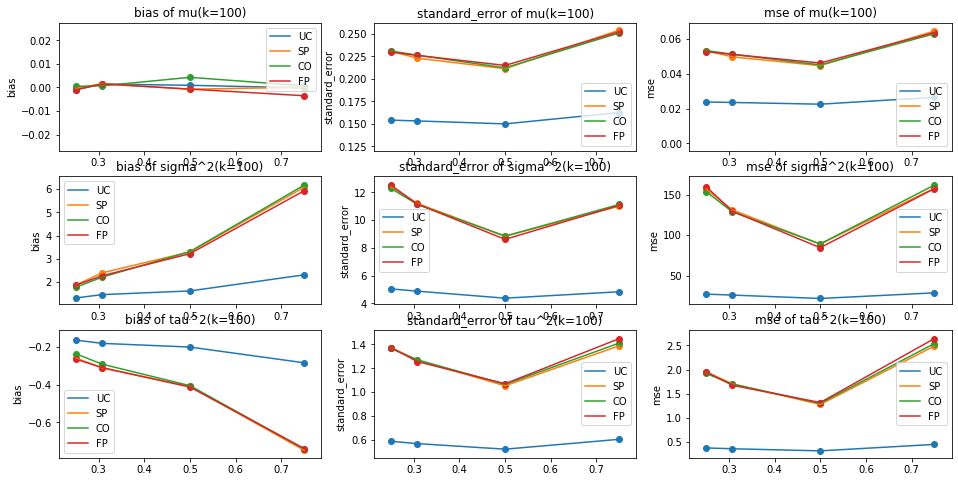

In [57]:
# plot of bias/standard_error/mse for mu/sigma^2/tau^2 with varying J^2 (when fix k=100)
fig = plt.figure(figsize=(16,8)) 
ax = fig.add_subplot(3,3,1)
plot_for_comparison('mu','bias','J^2', k=100,handler=ax)
ax = fig.add_subplot(3,3,2)
plot_for_comparison('mu','standard_error','J^2', k=100,handler=ax)
ax = fig.add_subplot(3,3,3)
plot_for_comparison('mu','mse','J^2', k=100,handler=ax)

ax = fig.add_subplot(3,3,4)
plot_for_comparison('sigma^2','bias','J^2', k=100,handler=ax)
ax = fig.add_subplot(3,3,5)
plot_for_comparison('sigma^2','standard_error','J^2', k=100,handler=ax)
ax = fig.add_subplot(3,3,6)
plot_for_comparison('sigma^2','mse','J^2', k=100,handler=ax)

ax = fig.add_subplot(3,3,7)
plot_for_comparison('tau^2','bias','J^2', k=100,handler=ax)
ax = fig.add_subplot(3,3,8)
plot_for_comparison('tau^2','standard_error','J^2', k=100,handler=ax)
ax = fig.add_subplot(3,3,9)
plot_for_comparison('tau^2','mse','J^2', k=100,handler=ax)


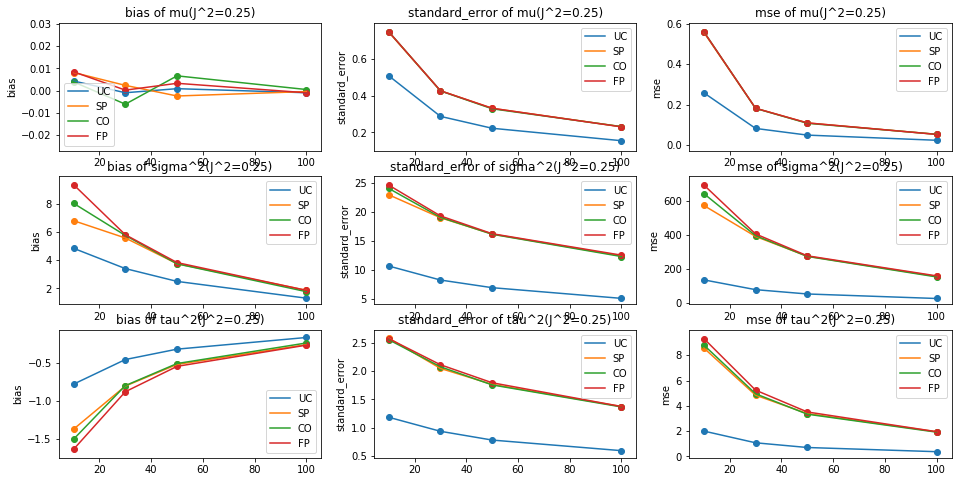

In [58]:
# plot of bias/standard_error/mse for mu/sigma^2/tau^2 with varying J^2 (when fix k=100)
fig = plt.figure(figsize=(16,8)) 
ax = fig.add_subplot(3,3,1)
plot_for_comparison('mu','bias','k', J_square=0.25,handler=ax)
ax = fig.add_subplot(3,3,2)
plot_for_comparison('mu','standard_error','k', J_square=0.25,handler=ax)
ax = fig.add_subplot(3,3,3)
plot_for_comparison('mu','mse','k', J_square=0.25,handler=ax)

ax = fig.add_subplot(3,3,4)
plot_for_comparison('sigma^2','bias','k', J_square=0.25,handler=ax)
ax = fig.add_subplot(3,3,5)
plot_for_comparison('sigma^2','standard_error','k', J_square=0.25,handler=ax)
ax = fig.add_subplot(3,3,6)
plot_for_comparison('sigma^2','mse','k', J_square=0.25,handler=ax)

ax = fig.add_subplot(3,3,7)
plot_for_comparison('tau^2','bias','k', J_square=0.25,handler=ax)
ax = fig.add_subplot(3,3,8)
plot_for_comparison('tau^2','standard_error','k', J_square=0.25,handler=ax)
ax = fig.add_subplot(3,3,9)
plot_for_comparison('tau^2','mse','k', J_square=0.25,handler=ax)
